# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

### Loading

In [63]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')

smaller_dataset = dataset
smaller_dataset["train"] = smaller_dataset["train"].filter(lambda e, i: i<20000, with_indices=True)
smaller_dataset["test"] = smaller_dataset["test"].filter(lambda e, i: i<400, with_indices=True)

Reusing dataset amazon_polarity (/Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?ba/s]

Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-438834447b4950f1.arrow


### BERT Tokenizer

In [83]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

In [84]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
smaller_tokenized_dataset = smaller_dataset.map(preprocess_function, batched=True)

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

Loading cached processed dataset at /Users/q_user/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/56923eeb72030cb6c4ea30c8a4e1162c26b25973475ac1f44340f0ec0f2936f4/cache-48722c425525a526.arrow


### Word embeddings

In [2]:
from gensim.models import KeyedVectors

model_word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
import nltk
from nltk.corpus import stopwords

def preprocess(sentence):
    nltk.word_tokenize(sentence)
    sentence = [word for word in sentence if word not in stopwords.words('english')]
    sentence = [model_word_vectors.get_vector(w) for w in sentence if w in model_word_vectors.key_to_index]
    return np.stack(sentence, axis=0).mean(0).reshape(300,) if len(sentence) > 0 else np.zeros(300,)

In [64]:
from tqdm import tqdm
import pandas as pd
from pandarallel import pandarallel
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

X_train_word_embeddings = np.stack(pd.Series(smaller_dataset["train"]["title"]).parallel_apply(lambda x: preprocess(x)).values, axis=0)
y_train_word_embeddings = np.array(smaller_dataset["train"]["label"])

X_test_word_embeddings = np.stack(pd.Series(smaller_dataset["test"]["title"]).parallel_apply(lambda x: preprocess(x)).values, axis=0)
y_test_word_embeddings = np.array(smaller_dataset["test"]["label"])

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Models

### BERT

In [85]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

In [86]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=smaller_tokenized_dataset["train"],
    eval_dataset=smaller_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, title.
***** Running training *****
  Num examples = 20000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6250


Step,Training Loss
500,0.407700
1000,0.355000
1500,0.294100
2000,0.259500
2500,0.260300
3000,0.176100
3500,0.186400
4000,0.151500
4500,0.135700
5000,0.126600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke

TrainOutput(global_step=6250, training_loss=0.20626280578613282, metrics={'train_runtime': 4073.3401, 'train_samples_per_second': 24.55, 'train_steps_per_second': 1.534, 'total_flos': 429173673614400.0, 'train_loss': 0.20626280578613282, 'epoch': 5.0})

In [87]:
import torch
predicted = trainer.predict(smaller_tokenized_dataset["test"])

predicted_proba = torch.nn.functional.softmax(torch.tensor(predicted.predictions), dim=1)
data_bert = predicted_proba[:,1].numpy(), np.array(smaller_tokenized_dataset["test"]["label"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: content, title.
***** Running Prediction *****
  Num examples = 400
  Batch size = 16


<AxesSubplot:ylabel='Count'>

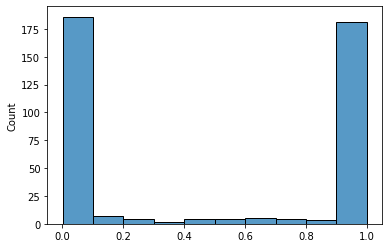

In [88]:
sns.histplot(data_bert[0])

### SVM

In [78]:
from sklearn import svm
from sklearn.ensemble import BaggingClassifier

n_estimators = 4
model_svm = BaggingClassifier(svm.SVC(probability=True), max_samples=1.0 / n_estimators, n_jobs=-1)
model_svm.fit(X_train_word_embeddings, y_train_word_embeddings)

BaggingClassifier(base_estimator=SVC(probability=True), max_samples=0.25,
                  n_jobs=-1)

In [79]:
data_svm = model_svm.predict_proba(X_test_word_embeddings)[:,1], np.array(y_test_word_embeddings)

<AxesSubplot:ylabel='Count'>

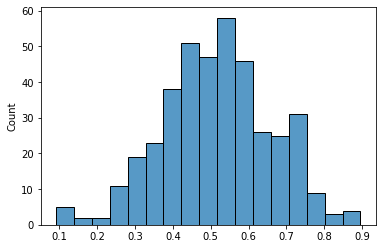

In [81]:
sns.histplot(data_svm[0])

### LightGBM

In [67]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_word_embeddings, y_train_word_embeddings)

LGBMClassifier()

In [68]:
data_lgb = model_lgb.predict_proba(X_test_word_embeddings)[:,1], np.array(y_test_word_embeddings)

<AxesSubplot:ylabel='Count'>

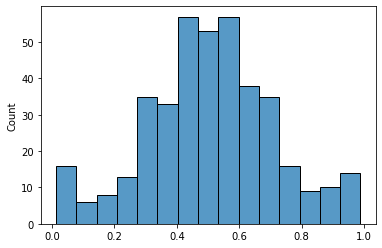

In [82]:
sns.histplot(data_lgb[0])

## Evaluation

**Supporting code**

In [28]:
import VennABERS
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt

def plot_venn_abers(data):
    venn_abers = VennABERS.ScoresToMultiProbs(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    plt.axis((0, 1, 0, 1))

def plot_isotonic_regression(data):
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))
    
def plot_all(data):
    venn_abers = VennABERS.ScoresToMultiProbs(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(10,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))
    
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(["Venn-Abers", "Venn-Abers Interval", "Isotonic Regression"])

In [ ]:
import VennABERS
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_venn_abers(data):
    venn_abers = VennABERS.ScoresToMultiProbs(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    plt.axis((0, 1, 0, 1))

def plot_isotonic_regression(data):
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))

def plot_all(data):
    venn_abers = VennABERS.ScoresToMultiProbs(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))
    
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.legend(["Venn-Abers", "Venn-Abers Interval", "Isotonic Regression", "Perfectly Calibrated"])

### BERT

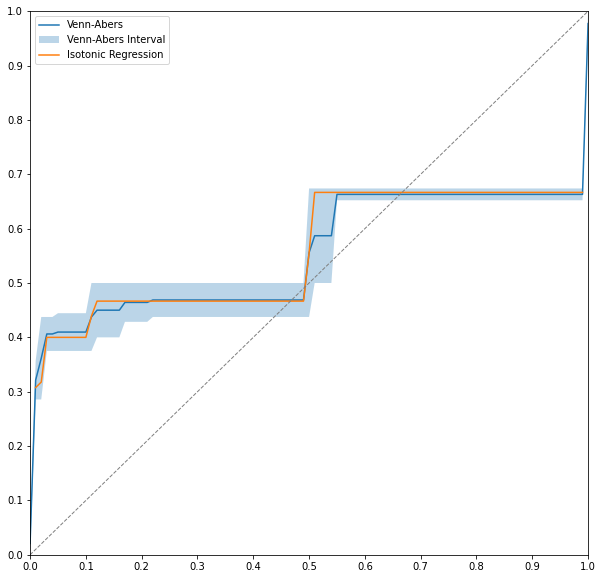

In [90]:
plot_all(data_bert)

### SVM

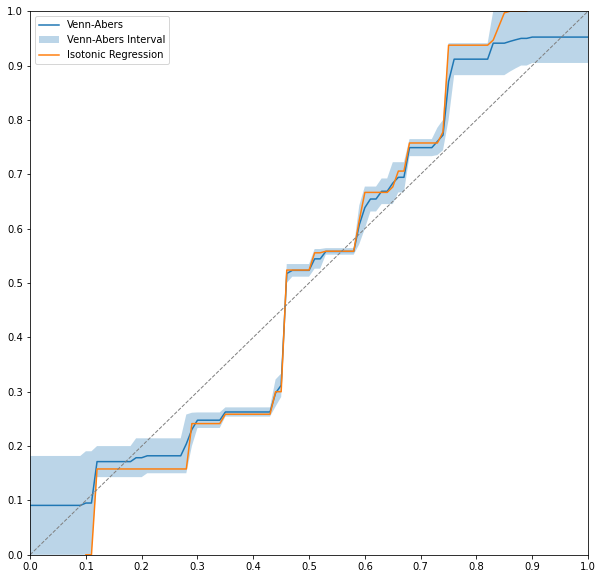

In [80]:
plot_all(data_svm)

### LightGBM

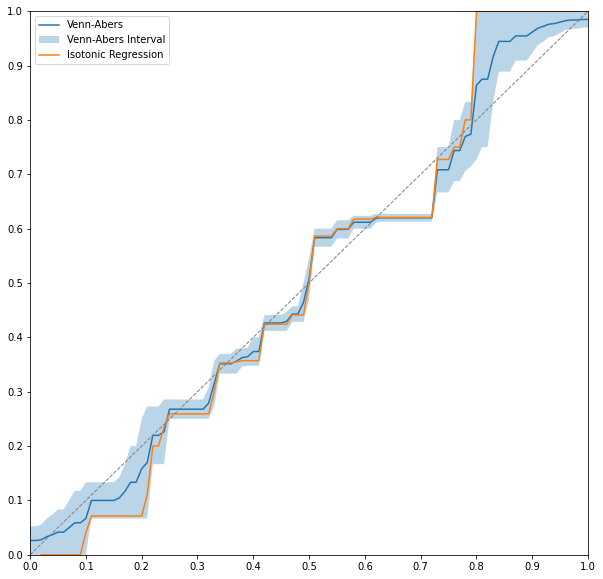

In [70]:
plot_all(data_lgb)